In [ ]:
pip install cleanvision

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets download ambarish/breakhis

 99% 3.96G/3.99G [00:50<00:00, 188MB/s]
100% 3.99G/3.99G [00:50<00:00, 84.1MB/s]


In [ ]:
! unzip breakhis

In [13]:
from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from cleanvision import Imagelab
from matplotlib import ticker
from PIL import Image
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [14]:
SEED = 51432
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [15]:
plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif", size=10.5)

In [16]:
fold_info = pd.read_csv("Folds.csv")
fold_info["label"] = fold_info["filename"].str.extract("(malignant|benign)")
fold_info.head()

fold  mag    grp                                           filename   label
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign

In [17]:
selected_fold = 2
selected_fold_data = fold_info.query("fold == @selected_fold")\
                              .copy().reset_index(drop=True)
selected_fold_data["filename"] = ("/content/BreaKHis_v1/"
                                  + selected_fold_data["filename"])

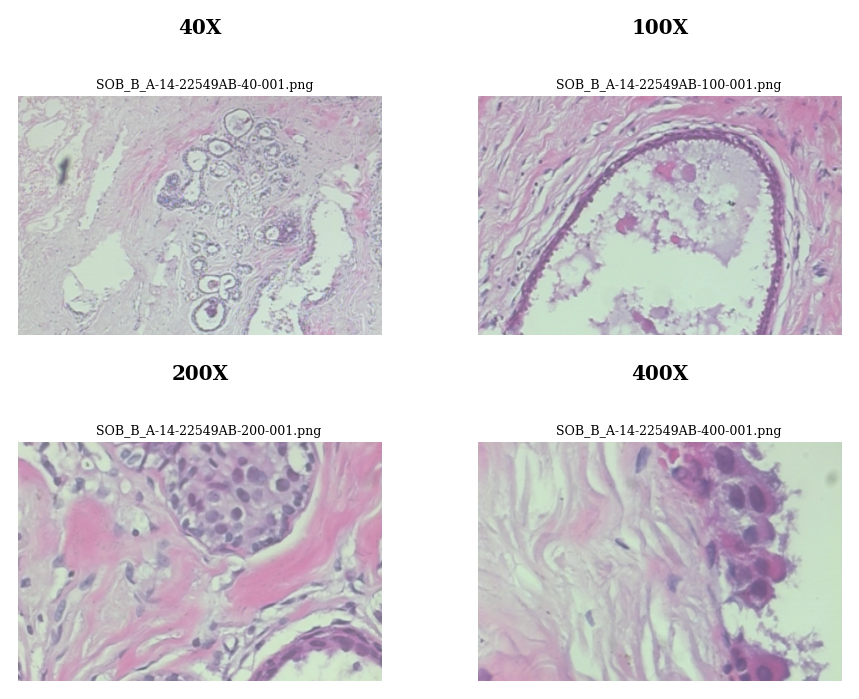

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4), dpi=180, tight_layout=True)
sample_images = selected_fold_data.groupby("mag", as_index=False).first()
for ax, row in zip(axes.flat, sample_images.itertuples()):
    img = Image.open(row.filename)
    ax.imshow(img)
    ax.set_title(f"{row.mag}X", size=8, pad=25, weight=600)
    ax.text(150, -15, row.filename.split("/")[-1], size=5)
    ax.axis("off")

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/7909 [00:00<?, ?it/s]

  0%|          | 0/7909 [00:00<?, ?it/s]

Issue checks completed. 256 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          250 |
|  1 | near_duplicates  |            6 |
|  2 | blurry           |            0 |
|  3 | dark             |            0 |
|  4 | grayscale        |            0 |
|  5 | light            |            0 |
|  6 | low_information  |            0 |
|  7 | odd_aspect_ratio |            0 |
|  8 | odd_size         |            0 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 250
Examples representing most severe instances of this issue:

Set: 0


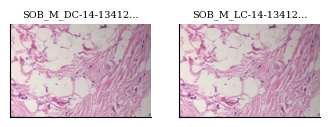

Set: 1


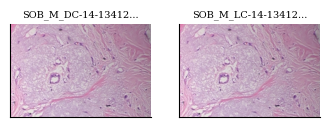

Set: 2


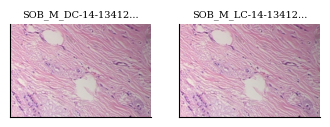

Set: 3


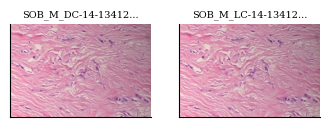

------------------ near_duplicates images ------------------

Number of examples with this issue: 6
Examples representing most severe instances of this issue:

Set: 0


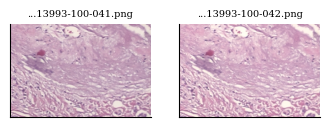

Set: 1


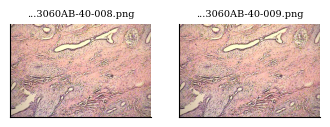

Set: 2


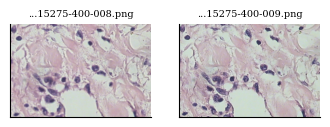

In [19]:
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()
imagelab.report(verbosity=4)

In [20]:
duplicated_images = imagelab.issues[
    ["is_exact_duplicates_issue", "is_near_duplicates_issue"]
].any(axis=1).reset_index().rename(columns={"index": "filename", 0: "duplicated"})
duplicated_images.head()

filename  duplicated
0  /content/BreaKHis_v1/BreaKHis_v1/histology_sli...       False
1  /content/BreaKHis_v1/BreaKHis_v1/histology_sli...       False
2  /content/BreaKHis_v1/BreaKHis_v1/histology_sli...       False
3  /content/BreaKHis_v1/BreaKHis_v1/histology_sli...       False
4  /content/BreaKHis_v1/BreaKHis_v1/histology_sli...       False

In [21]:
assert duplicated_images["filename"].equals(selected_fold_data["filename"])

selected_fold_data = selected_fold_data[~duplicated_images["duplicated"]]
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/7653 [00:00<?, ?it/s]

  0%|          | 0/7653 [00:00<?, ?it/s]

Issue checks completed. 0 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


In [22]:
train = selected_fold_data.query("mag >= 200 and grp == 'train'")
test = selected_fold_data.query("mag >= 200 and grp == 'test'")
train.shape, test.shape

((2566, 5), (1149, 5))

In [23]:
IMG_SIZE = 224
BATCH_SIZE = 28

def load_image(filename: str, label: int) -> Tuple[tf.Tensor, str]:
    file = tf.io.read_file(filename)
    img = tf.image.decode_png(file, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    return img, label

In [24]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train["label"].value_counts(ascending=True)

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(train["filename"],
                                                      train["label"].map(classes), random_state=SEED)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                .map(load_image).batch(BATCH_SIZE)
validation_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))\
                .map(load_image).batch(BATCH_SIZE)

In [26]:
test = test.sample(frac=1, random_state=SEED)
test_ds = tf.data.Dataset.from_tensor_slices((test["filename"],
                                              test["label"].map(classes))
).map(load_image).batch(BATCH_SIZE)

In [27]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

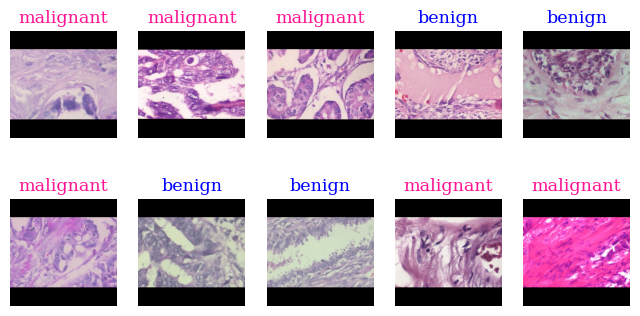

In [28]:
plt.figure(figsize=(8, 4))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        label = class_names[labels[i]]
        title_color = "blue" if label == "benign" else "deeppink"
        plt.title(class_names[labels[i]], color=title_color)
        plt.axis("off")

In [29]:
sample_image = load_image(*train[["filename", "label"]].iloc[0])[0]

def plot_augmentations(augmentation_layer: tf.keras.layers.Layer) -> None:
    augment_name = augmentation_layer.name
    fig, (ax0, *axes) = plt.subplots(ncols=4, figsize=(8, 4))
    ax0.imshow(sample_image.numpy().astype("uint8"))
    ax0.set_title("Original", size=10, pad=10)
    ax0.axis("off")
    for idx, ax in enumerate(axes):
        augmented_image = augmentation_layer(sample_image)
        ax.imshow(augmented_image.numpy().astype("uint8"))
        ax.set_title(augment_name.title(), size=10, pad=10)
        ax.axis("off")

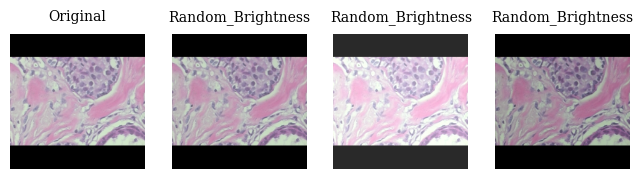

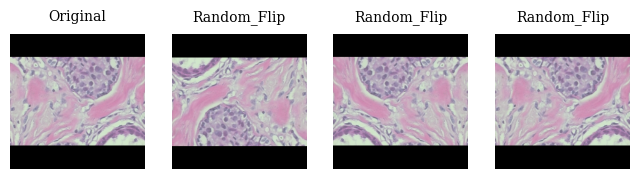

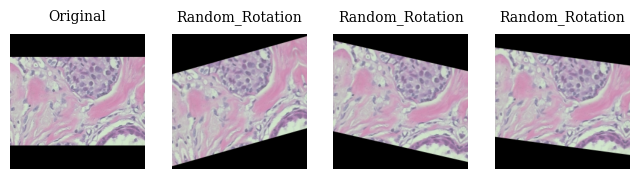

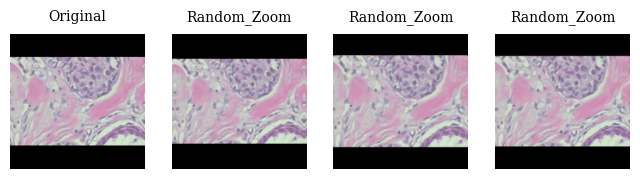

In [30]:
plot_augmentations(layers.RandomBrightness(0.2))
plot_augmentations(layers.RandomFlip())
plot_augmentations(layers.RandomRotation(0.2, seed=SEED))
plot_augmentations(layers.RandomZoom(0.2, seed=SEED))

In [31]:
pretrained_vgg16_base = tf.keras.applications.vgg16.VGG16(include_top=False,
                                          input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights="imagenet",pooling="avg",)
pretrained_vgg16_base.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [32]:
vgg16_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    layers.Lambda(tf.keras.applications.vgg16.preprocess_input),
    pretrained_vgg16_base,
    layers.Dropout(0.4),
    layers.Dense(384, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")], name="VGG16")

vgg16_model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_1 (Rando  (None, 224, 224, 3)       0         
 mBrightness)                                                    
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [33]:
from tensorflow.keras import models, optimizers

In [34]:
vgg16_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss='binary_crossentropy',metrics=['accuracy'])

In [36]:
early_stopping = EarlyStopping(min_delta=1e-4, patience=5, verbose=1,
                                   restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, verbose=1)
vgg16_history = vgg16_model.fit(train_ds,epochs=25,
                                validation_data=validation_ds,
                                callbacks=[early_stopping, reduce_lr])

Epoch 1/25
69/69 [==============================] - 11s 166ms/step - loss: 0.4197 - accuracy: 0.8108 - val_loss: 0.3896 - val_accuracy: 0.8396 - lr: 5.0000e-04
Epoch 2/25
69/69 [==============================] - 12s 175ms/step - loss: 0.4067 - accuracy: 0.8176 - val_loss: 0.3704 - val_accuracy: 0.8598 - lr: 5.0000e-04
Epoch 3/25
69/69 [==============================] - 12s 176ms/step - loss: 0.4158 - accuracy: 0.8082 - val_loss: 0.3736 - val_accuracy: 0.8629 - lr: 5.0000e-04
Epoch 4/25
69/69 [==============================] - 12s 173ms/step - loss: 0.4076 - accuracy: 0.8285 - val_loss: 0.3771 - val_accuracy: 0.8645 - lr: 5.0000e-04
Epoch 5/25
69/69 [==============================] - 12s 168ms/step - loss: 0.3988 - accuracy: 0.8176 - val_loss: 0.3664 - val_accuracy: 0.8660 - lr: 5.0000e-04
Epoch 6/25
69/69 [==============================] - 11s 163ms/step - loss: 0.3942 - accuracy: 0.8274 - val_loss: 0.3846 - val_accuracy: 0.8598 - lr: 5.0000e-04
Epoch 7/25
69/69 [======================

In [40]:
test_loss_VGG, test_accuracy_VGG = vgg16_model.evaluate(validation_ds)
print(f"Test Accuracy: {test_accuracy_VGG*100:.2f}")
print(f"Test Loss: {test_loss_VGG:.4f}")

23/23 [==============================] - 3s 125ms/step - loss: 0.3604 - accuracy: 0.8598
Test Accuracy: 85.98
Test Loss: 0.3604


In [41]:
results = [(labels, vgg16_model.predict(images, verbose=0).reshape(-1))
               for images, labels in test_ds.take(-1)]
labels = np.concatenate([x[0] for x in results])
preds = np.concatenate([x[1] for x in results])

In [42]:
pretrained_mobnet_base = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",
)
pretrained_mobnet_base.trainable = False

12683000/12683000 [==============================] - 0s 0us/step


In [43]:
mobnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input),
    pretrained_mobnet_base,
    layers.Dropout(0.4),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")], name="MobileNetV3")

mobnet_model.summary()

Model: "MobileNetV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_2 (Rando  (None, 224, 224, 3)       0         
 mBrightness)                                                    
                                                                 
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Function  (None, 960)               2996352   
 al)                                                             
                                                       

In [44]:
mobnet_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss='binary_crossentropy',metrics=['accuracy'])

In [47]:
mobnet_history = mobnet_model.fit(train_ds,epochs=25,
                                validation_data=validation_ds,
                                callbacks=[early_stopping, reduce_lr])

Epoch 1/25
69/69 [==============================] - 8s 51ms/step - loss: 0.6382 - accuracy: 0.6538 - val_loss: 0.5223 - val_accuracy: 0.7430 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - 4s 59ms/step - loss: 0.5334 - accuracy: 0.7277 - val_loss: 0.4561 - val_accuracy: 0.7757 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - 3s 47ms/step - loss: 0.5280 - accuracy: 0.7271 - val_loss: 0.4638 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - 3s 47ms/step - loss: 0.4997 - accuracy: 0.7453 - val_loss: 0.4621 - val_accuracy: 0.7477 - lr: 0.0010
Epoch 5/25
69/69 [==============================] - 4s 55ms/step - loss: 0.4768 - accuracy: 0.7812 - val_loss: 0.4846 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 6/25
69/69 [==============================] - 3s 49ms/step - loss: 0.4552 - accuracy: 0.7786 - val_loss: 0.4432 - val_accuracy: 0.7664 - lr: 0.0010
Epoch 7/25
69/69 [==============================] - 4s 58ms/step - loss: 0.4

In [48]:
test_loss_mob, test_accuracy_mob = mobnet_model.evaluate(validation_ds)
print(f"Test Accuracy: {test_accuracy_mob*100:.2f}")
print(f"Test Loss: {test_loss_mob:.4f}")

23/23 [==============================] - 1s 35ms/step - loss: 0.4021 - accuracy: 0.8115
Test Accuracy: 81.15
Test Loss: 0.4021


In [49]:
pretrained_resnet_base = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights="imagenet",
    pooling="avg",)

pretrained_resnet_base.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


In [50]:
resnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input),
    pretrained_resnet_base,
    layers.Dropout(0.4),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")], name="ResNet50V2")

resnet_model.summary()

Model: "ResNet50V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_3 (Rando  (None, 224, 224, 3)       0         
 mBrightness)                                                    
                                                                 
 random_flip_3 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_3 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0

In [51]:
resnet_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                    loss='binary_crossentropy',metrics=['accuracy'])

In [52]:
resnet_history = resnet_model.fit(train_ds,epochs=25,
                                validation_data=validation_ds,
                                callbacks=[early_stopping, reduce_lr])

Epoch 1/25
69/69 [==============================] - 13s 138ms/step - loss: 0.5868 - accuracy: 0.7095 - val_loss: 0.4448 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - 8s 116ms/step - loss: 0.4653 - accuracy: 0.7900 - val_loss: 0.4389 - val_accuracy: 0.8349 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - 8s 118ms/step - loss: 0.4531 - accuracy: 0.7968 - val_loss: 0.3898 - val_accuracy: 0.8193 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - 8s 118ms/step - loss: 0.4012 - accuracy: 0.8243 - val_loss: 0.3615 - val_accuracy: 0.8396 - lr: 0.0010
Epoch 5/25
69/69 [==============================] - 8s 113ms/step - loss: 0.3871 - accuracy: 0.8332 - val_loss: 0.3721 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 6/25
69/69 [==============================] - 8s 116ms/step - loss: 0.3793 - accuracy: 0.8430 - val_loss: 0.3376 - val_accuracy: 0.8411 - lr: 0.0010
Epoch 7/25
69/69 [==============================] - 8s 120ms/step - l

In [53]:
test_loss_res, test_accuracy_res = resnet_model.evaluate(validation_ds)
print(f"Test Accuracy: {test_accuracy_res*100:.2f}")
print(f"Test Loss: {test_loss_res:.4f}")

23/23 [==============================] - 2s 83ms/step - loss: 0.3197 - accuracy: 0.8583
Test Accuracy: 85.83
Test Loss: 0.3197


In [78]:
fitted_models = [vgg16_model, mobnet_model,resnet_model]
test_metrics = pd.DataFrame(
    {model.name: model.evaluate(validation_ds, verbose=0) for model in fitted_models},
    index=["Loss", "Accuracy"])
test_metrics.style.highlight_min(color="yellow", axis=None)\
                  .highlight_max(color="lawngreen", axis=None)

In [79]:
hist_list = [vgg16_history, mobnet_history, resnet_history]
train_metrics = pd.concat([pd.DataFrame(hist.history) for hist in hist_list],
                          axis=1, keys=[hist.model.name for hist in hist_list])
color_dict = dict(zip(test_metrics, plt.colormaps["Set2"].colors))

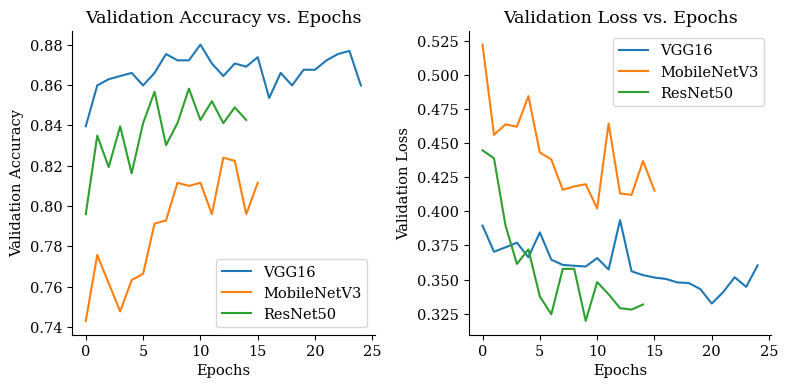

In [80]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(vgg16_history.history['val_accuracy'], label='VGG16')
plt.plot(mobnet_history.history['val_accuracy'], label='MobileNetV3')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet50')
plt.title('Validation Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg16_history.history['val_loss'], label='VGG16')
plt.plot(mobnet_history.history['val_loss'], label='MobileNetV3')
plt.plot(resnet_history.history['val_loss'], label='ResNet50')
plt.title('Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [81]:
def plot_predictions(model: tf.keras.Model) -> None:
    plt.figure(figsize=(14, 9))
    for images, labels in test_ds.take(1):
        labels = labels.numpy()
        predicted_labels = model.predict(images).round().astype("uint8").reshape(-1,)
        print("Predicted:", predicted_labels)
        print("Actual:   ", labels)
        for i, (pred, actual) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(4, 7, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if pred == actual:
                plt.title(class_names[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_names[predicted_labels[i]]}\n"
                          + f"(Actual: {class_names[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

1/1 [==============================] - 0s 42ms/step
Predicted: [1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1]
Actual:    [1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1]


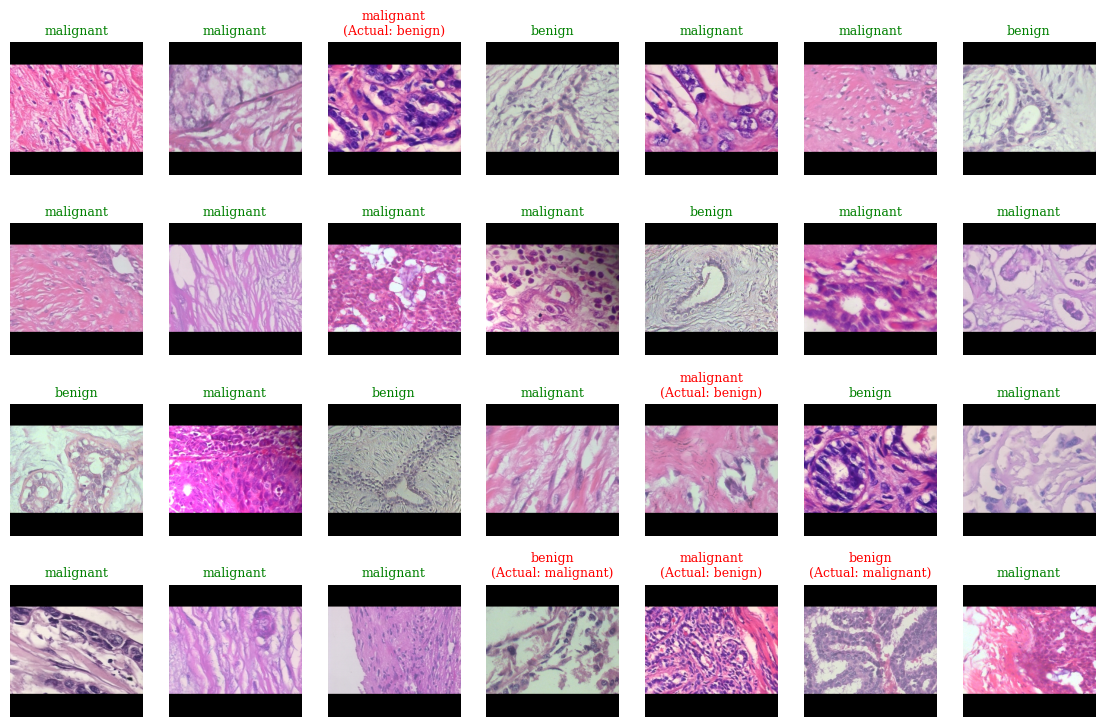

In [75]:
plot_predictions(vgg16_model)

1/1 [==============================] - 3s 3s/step
Predicted: [1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1]
Actual:    [1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1]


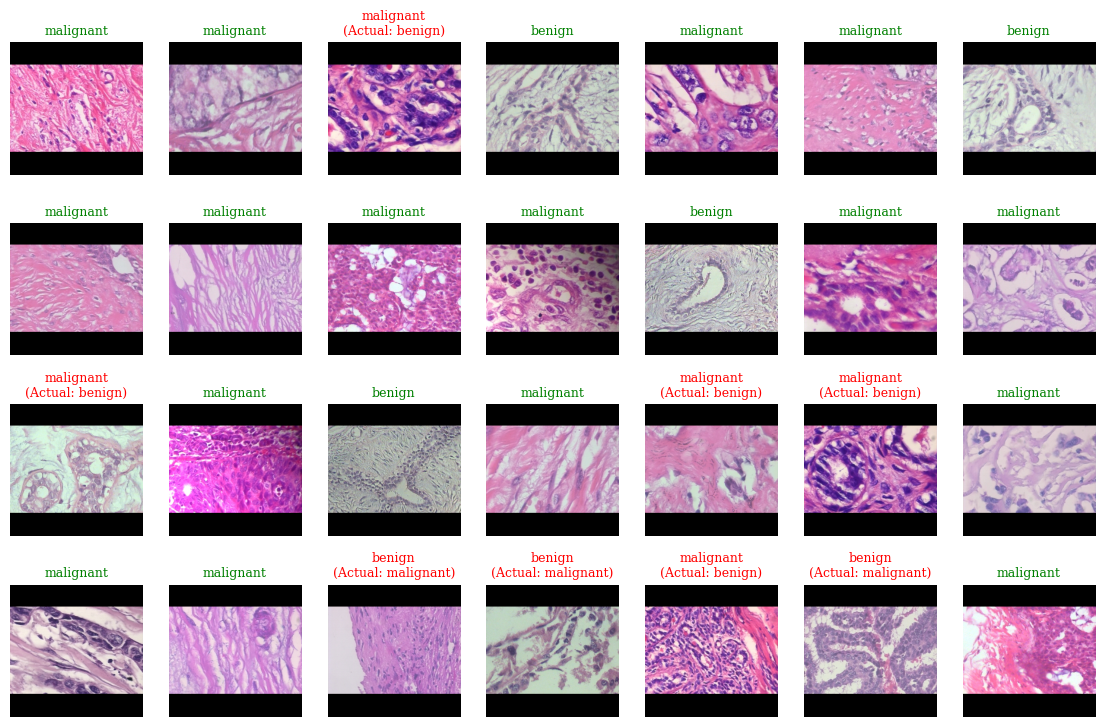

In [76]:
plot_predictions(mobnet_model)

1/1 [==============================] - 1s 1s/step
Predicted: [1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1]
Actual:    [1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1]


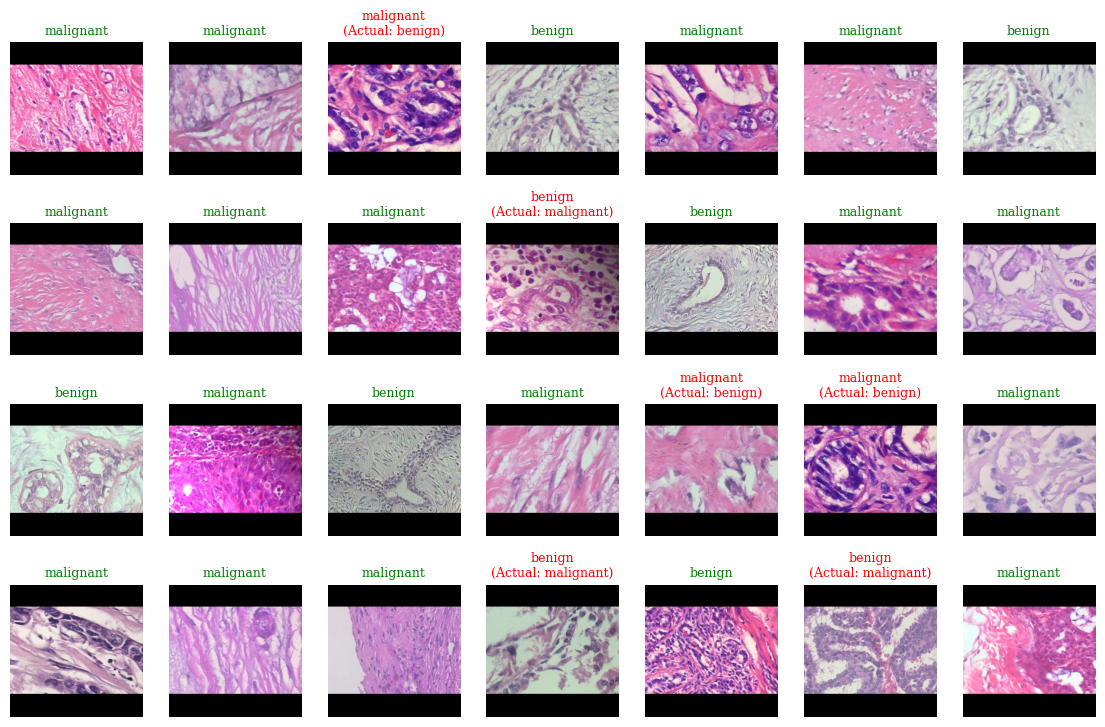

In [77]:
plot_predictions(resnet_model)